## **Predicción diaria del precio de las acciones de la minera FSM utilizando un modelo combinado de LSTM y SVR**

**Integrantes del equipo:**
- **Romero Cisneros** - Karlo Brandi
- **Hernandez Bianchi** - Stefano Alessandro 

En este notebook, realizaremos la predicción diaria del precio de cierre de las acciones de la minera FSM (Fortuna Silver Mines Inc.) utilizando un modelo combinado de LSTM y SVR.

### **1. Importación de bibliotecas**

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
import matplotlib.dates as mdates
import seaborn as sns  # Para gráficos estadísticos

### **2. Descargar datos**
Descargamos los datos históricos de las acciones de FSM desde Yahoo Finance.

In [2]:
# Descargar datos de Yahoo Finance
data = yf.download("FSM", start="2019-01-01", end="2023-12-31")

# Mostrar las primeras filas de los datos
data.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,3.67,3.77,3.62,3.68,3.68,969400
2019-01-03,3.71,3.82,3.68,3.79,3.79,848300
2019-01-04,3.77,3.84,3.73,3.78,3.78,770400
2019-01-07,3.80,3.84,3.67,3.70,3.70,633800
2019-01-08,3.69,3.87,3.67,3.85,3.85,738800


### **3. Exploración y preprocesamiento de datos**
Exploramos los datos descargados y realizamos preprocesamiento si es necesario.

In [3]:
# Mostrar todos los datos
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,3.67,3.77,3.62,3.68,3.68,969400
2019-01-03,3.71,3.82,3.68,3.79,3.79,848300
2019-01-04,3.77,3.84,3.73,3.78,3.78,770400
2019-01-07,3.80,3.84,3.67,3.70,3.70,633800
2019-01-08,3.69,3.87,3.67,3.85,3.85,738800
...,...,...,...,...,...,...
2023-12-22,4.03,4.15,3.96,3.96,3.96,5210000
2023-12-26,3.98,4.00,3.90,3.98,3.98,1946400
2023-12-27,4.01,4.11,3.97,4.00,4.00,4162500


In [4]:
# Obtener la forma de los datos (número de filas y columnas)
data.shape

(1258, 6)

#### **Información general de los datos**

In [5]:
# Mostrar información general de los datos
print("Información general de los datos:")
print(data.info())

Información general de los datos:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2019-01-02 to 2023-12-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1258 non-null   float64
 1   High       1258 non-null   float64
 2   Low        1258 non-null   float64
 3   Close      1258 non-null   float64
 4   Adj Close  1258 non-null   float64
 5   Volume     1258 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.8 KB
None


#### **Estadísticas descriptivas de los datos**

In [6]:
# Mostrar estadísticas descriptivas de los datos
print("\nEstadísticas descriptivas de los datos:")
print(data.describe())


Estadísticas descriptivas de los datos:
              Open         High          Low        Close    Adj Close  \
count  1258.000000  1258.000000  1258.000000  1258.000000  1258.000000   
mean      4.174300     4.272091     4.064094     4.164523     4.164523   
std       1.513419     1.546329     1.466581     1.508172     1.508172   
min       1.660000     2.180000     1.470000     1.800000     1.800000   
25%       3.152500     3.220000     3.080000     3.160000     3.160000   
50%       3.710000     3.780000     3.630000     3.700000     3.700000   
75%       4.480000     4.620000     4.330000     4.460000     4.460000   
max       9.480000     9.850000     9.120000     9.540000     9.540000   

             Volume  
count  1.258000e+03  
mean   3.736393e+06  
std    2.280113e+06  
min    2.466000e+05  
25%    2.343275e+06  
50%    3.372650e+06  
75%    4.658625e+06  
max    3.585730e+07  


### **4. Visualización de datos**

Visualizamos los datos para comprender mejor su distribución y tendencias.

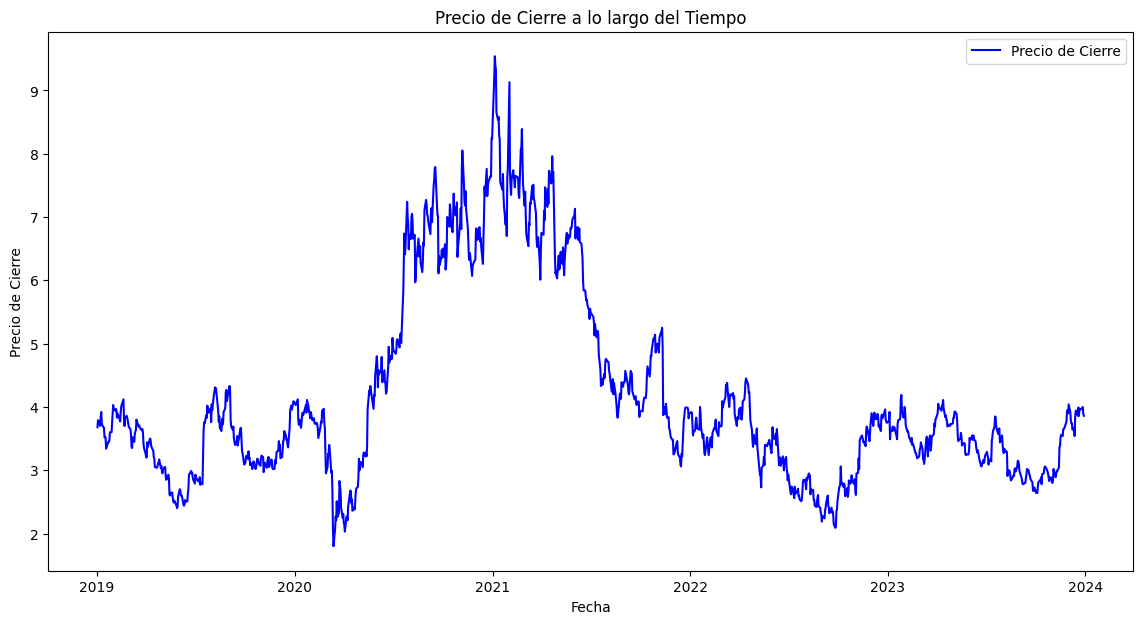

In [7]:
# Graficar el precio de cierre a lo largo del tiempo
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Precio de Cierre', color='blue')
plt.title('Precio de Cierre a lo largo del Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()

#### **Histograma**

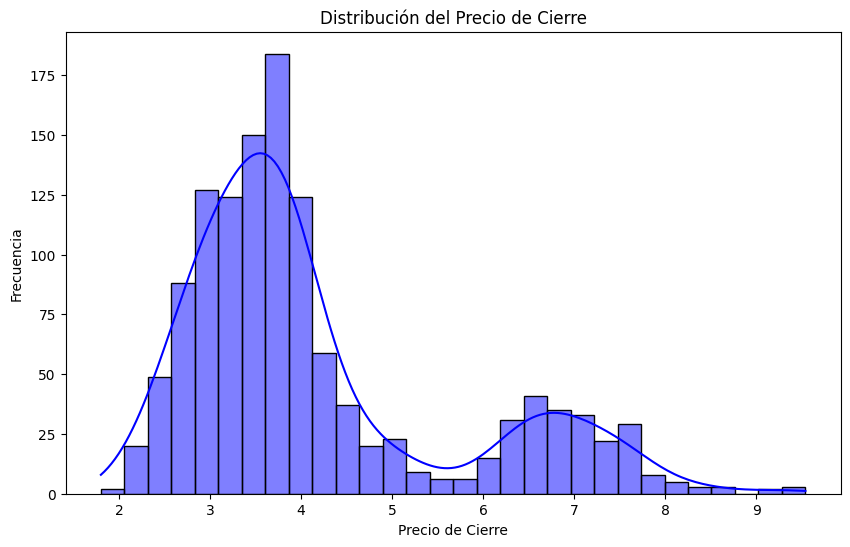

In [8]:
# Graficar la distribución del precio de cierre
plt.figure(figsize=(10, 6))
sns.histplot(data['Close'], bins=30, kde=True, color='blue')
plt.title('Distribución del Precio de Cierre')
plt.xlabel('Precio de Cierre')
plt.ylabel('Frecuencia')
plt.show()

#### **Matriz de Correlación**

In [9]:
# Calcular la matriz de correlación entre las variables del conjunto de datos
data.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.998105,0.997833,0.995443,0.995443,0.082039
High,0.998105,1.000000,0.997531,0.997901,0.997901,0.096713
Low,0.997833,0.997531,1.000000,0.998080,0.998080,0.060505
Close,0.995443,0.997901,0.998080,1.000000,1.000000,0.075692
Adj Close,0.995443,0.997901,0.998080,1.000000,1.000000,0.075692
Volume,0.082039,0.096713,0.060505,0.075692,0.075692,1.000000


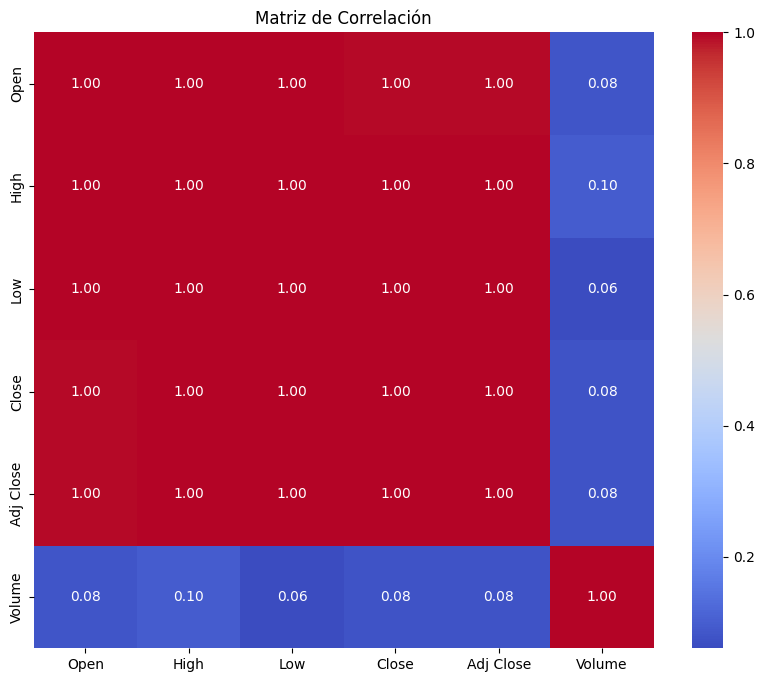

In [10]:
# Graficar la matriz de correlación
plt.figure(figsize=(10, 8))  # Establecer el tamaño de la figura
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt=".2f")  # Crear el mapa de calor con anotaciones y formato decimal de dos lugares
plt.title('Matriz de Correlación')  # Establecer el título del gráfico
plt.show()  # Mostrar el gráfico

### **5. Preparación de datos para el modelo**
Preparamos los datos para el entrenamiento del modelo, incluyendo la normalización.

In [11]:
# Seleccionar las variables 'Open', 'High', 'Low' y 'Close' del conjunto de datos y convertirlas en un arreglo de numpy
features = data[['Open', 'High', 'Low', 'Close']].values
features

array([[3.67000008, 3.76999998, 3.61999989, 3.68000007],
       [3.71000004, 3.81999993, 3.68000007, 3.78999996],
       [3.76999998, 3.83999991, 3.73000002, 3.77999997],
       ...,
       [4.01000023, 4.11000013, 3.97000003, 4.        ],
       [3.98000002, 4.01000023, 3.8900001 , 3.8900001 ],
       [3.83999991, 3.92000008, 3.75      , 3.8599999 ]])

In [12]:
# Imprimir la forma (shape) del arreglo de características
print(features.shape)

(1258, 4)


In [13]:
target = features[:, 3].reshape(-1, 1)

#### **Normalización**

In [14]:
# Normalización de las características
scaler_features = MinMaxScaler(feature_range=(0, 1))
scaler_target = MinMaxScaler(feature_range=(0, 1))

features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target)

#### **Características Escaladas**

In [15]:
# Mostrar las características escaladas
print(features_scaled)

[[0.25703328 0.20730115 0.28104574 0.24289407]
 [0.26214836 0.21382005 0.2888889  0.25710594]
 [0.26982099 0.21642761 0.29542484 0.25581396]
 ...
 [0.30051156 0.25162972 0.32679739 0.28423773]
 [0.29667521 0.23859193 0.31633989 0.27002586]
 [0.27877239 0.22685788 0.29803922 0.26614986]]


#### **Objetivo Escalado**

In [16]:
# Mostrar la variable objetivo escalada
print(target_scaled)

[[0.24289407]
 [0.25710594]
 [0.25581396]
 ...
 [0.28423773]
 [0.27002586]
 [0.26614986]]


### **6. División en conjuntos de entrenamiento y prueba**

#### **Separar los datos en características (X) y variable objetivo (y)**

In [17]:
# Separar los datos en características y objetivo
X = features_scaled[:-1]
y = target_scaled[1:]

In [18]:
# Matriz de características (X)
print(X)

[[0.25703328 0.20730115 0.28104574 0.24289407]
 [0.26214836 0.21382005 0.2888889  0.25710594]
 [0.26982099 0.21642761 0.29542484 0.25581396]
 ...
 [0.29667521 0.23728812 0.31764707 0.28165376]
 [0.30051156 0.25162972 0.32679739 0.28423773]
 [0.29667521 0.23859193 0.31633989 0.27002586]]


In [19]:
# Imprimir la forma (shape) de la matriz de características X
print(X.shape)

(1257, 4)


In [20]:
# Vector de variable objetivo (y)
print(y)

[[0.25710594]
 [0.25581396]
 [0.24547805]
 ...
 [0.28423773]
 [0.27002586]
 [0.26614986]]


In [21]:
# Imprimir la forma (shape) del vector de variable objetivo y
print(y.shape)

(1257, 1)


#### **Separar los datos en conjuntos de entrenamiento y prueba**

In [22]:
# Se utiliza un 80% de los datos para entrenamiento y un 20% para prueba
# Los datos no se mezclan (shuffle=False) para mantener el orden temporal
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [23]:
# Imprimir la forma (shape) de la matriz de características X_train (conjunto de entrenamiento)
print(X_train.shape)

(1005, 4)


In [24]:
# Imprimir la forma (shape) del vector de la variable objetivo y_train (conjunto de entrenamiento)
print(y_train.shape)

(1005, 1)


In [25]:
# Imprimir la forma (shape) de la matriz de características X_test (conjunto de prueba)
print(X_test.shape)

(252, 4)


In [26]:
# Imprimir la forma (shape) del conjunto de prueba de la variable objetivo (y_test)
print(y_test.shape)

(252, 1)


### **7. Definición y entrenamiento del modelo combinado**

In [27]:
# Optimizar y Entrenar Modelo SVR
def optimize_svm(X_train, y_train):
    param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [
        0.1, 0.01, 0.001], 'kernel': ['rbf']}
    grid = GridSearchCV(SVR(), param_grid, refit=True,
                        cv=TimeSeriesSplit(n_splits=5))
    grid.fit(X_train, y_train.ravel())
    return grid.best_estimator_

In [28]:
svr_model = optimize_svm(X_train, y_train)

In [29]:
# Entrenar Modelo LSTM
def train_lstm(X_train, y_train, input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=50, batch_size=32,
                validation_split=0.2, verbose=0)
    return model

In [30]:
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

lstm_model = train_lstm(X_train_lstm, y_train, (1, X_train.shape[1]))

c:\Users\karlo\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### **7. Evaluación del modelo**
Evaluamos el modelo utilizando métricas como el MAPE y el RMSE.

In [31]:
# Predicciones
svr_predictions = scaler_target.inverse_transform(
    svr_model.predict(X_test).reshape(-1, 1))
lstm_predictions = scaler_target.inverse_transform(
    lstm_model.predict(X_test_lstm))

combined_predictions = np.median(
    [svr_predictions, lstm_predictions], axis=0)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


#### **Comparación entre Predicciones y Valores Reales del Conjunto de Prueba**

(array([19358., 19417., 19478., 19539., 19601., 19662., 19723.]),
 [Text(19358.0, 0, 'Jan 2023'),
  Text(19417.0, 0, 'Mar 2023'),
  Text(19478.0, 0, 'May 2023'),
  Text(19539.0, 0, 'Jul 2023'),
  Text(19601.0, 0, 'Sep 2023'),
  Text(19662.0, 0, 'Nov 2023'),
  Text(19723.0, 0, 'Jan 2024')])

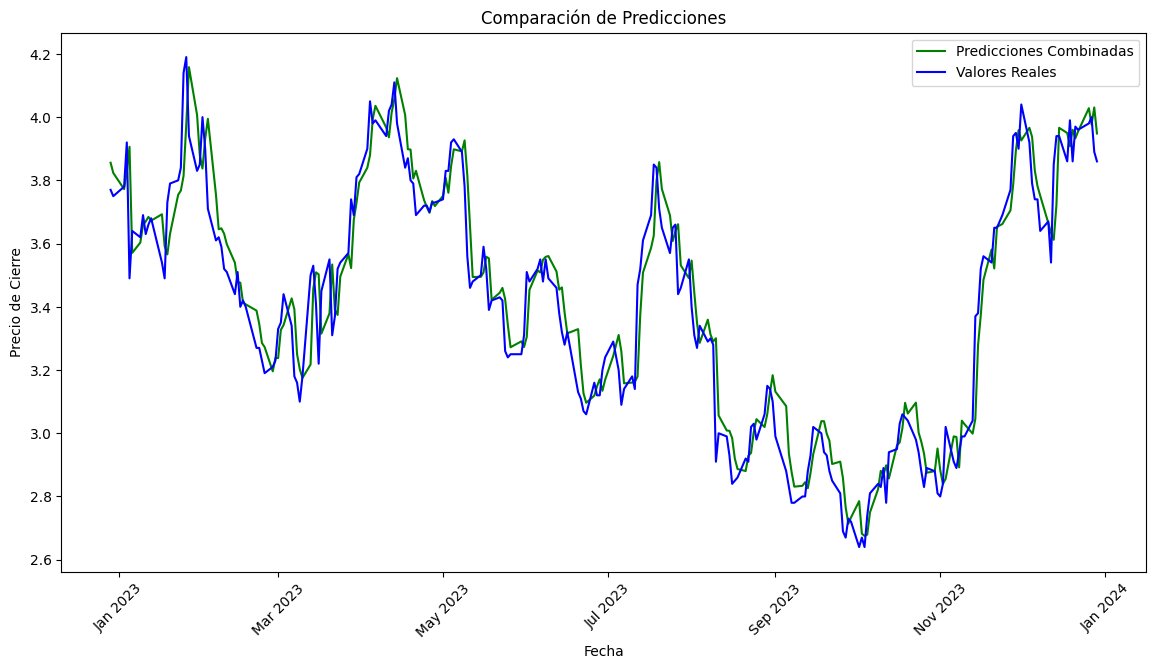

In [32]:
# Visualización de los resultados
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(data.index[-len(combined_predictions):], combined_predictions,
        label='Predicciones Combinadas', color='green')
ax.plot(data.index[-len(y_test):], scaler_target.inverse_transform(y_test),
        label='Valores Reales', color='blue')
ax.set_title('Comparación de Predicciones')
ax.set_xlabel('Fecha')
ax.set_ylabel('Precio de Cierre')
ax.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)

#### **Metrica de errores**

In [33]:
# Evaluación del modelo combinado: MAPE y RMSE
mape_combined = mean_absolute_percentage_error(
    scaler_target.inverse_transform(y_test), combined_predictions)
rmse_combined = np.sqrt(mean_squared_error(
    scaler_target.inverse_transform(y_test), combined_predictions))

print(f'MAPE del Modelo Combinado: {mape_combined:.4f}')
print(f'RMSE del Modelo Combinado: {rmse_combined:.4f}')

MAPE del Modelo Combinado: 0.0246
RMSE del Modelo Combinado: 0.1102
